## 452 - Machine Learning - Assignment 1 : Titanic Survival Analysis

##### This is my very first Kaggle project as a Python beginner and hence I have used very basic methods/techniques with the little knowledge I have and help from online resources to complete the assignment. References are provided at the end of this notebook.
#### Quick overview of the project - 
The task is to predict the survival on the Titanic based on the dataset of the onboard passengers of the historical journey embarked on April 15, 1912. It requires a binary classification of 1/0, 1 meaning Survived and 0 meaning not survived. The prediction output is submitted on Kaggle and the code is also available on Github under Titanic survival Analysis folder in the following repository - https://github.com/p-sama/BAX-ML.git. The input dataset has been split into training and testing sets which are available to the public through Kaggle (Link provided in the code). The output requirement is a CSV file with 2 columns - PassengerID and Survival prediction (1/0).

#### The basic steps involved in executing this project are as follows :-

##### Step 1: Gather the Data & Utilities
•	Importing the required libraries

•	Reading and getting acquainted with the data

##### Step 2: Pre-process & Analyze the Data
•	Cleaning, Treating missing values

•	Perform EDA & Visualization

##### Step 3: Model Development
•	Feature Engineering

•	Developing the Prelim models

•	Cross-validation and choosing the final model

##### Step 4: Make predictions on the unseen data
•	Transform Test Data

•	Predict the required output

### Step 1: Gather the Data & Utilities

In [217]:
# Loading the required libraries/packages

# For data loading and manipulation
import pandas as pd
import numpy as np

# For Visualization/EDA
import seaborn as sns
sns.set(style="white")
import matplotlib.pyplot as plt
%matplotlib inline

# For data science and machine learning techniques
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

In [218]:
# Read the train and test datasets from Kaggle to create two DataFrames using Pandas
train_loc = "http://s3.amazonaws.com/assets.datacamp.com/course/Kaggle/train.csv"
test_loc = "http://s3.amazonaws.com/assets.datacamp.com/course/Kaggle/test.csv"
train = pd.read_csv(train_loc)
test = pd.read_csv(test_loc)
# Print the first few records of the train and test datasets
print(train.head())
print(test.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
  

In [219]:
# Checking the dimensions of the train dataset
train.shape

(891, 12)

In [220]:
# Checking the distribution of the numerical columns
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [221]:
# Getting a summary on data types and missingness of each column
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


### Step 2: Pre-process & Analyze the Data

In [222]:
# Treating missing values (Age, Cabin, Embarked)
# Check the average Age by Gender
train.groupby('Sex')['Age'].mean()

Sex
female    27.915709
male      30.726645
Name: Age, dtype: float64

In [223]:
# Impute missing values of age by the respective average of the genders
train.loc[(train.Age.isnull())&(train.Sex=='female'),'Age'] = train["Age"][train["Sex"] == 'female'].mean()
train.loc[(train.Age.isnull())&(train.Sex=='male'),'Age'] = train["Age"][train["Sex"] == 'male'].mean()
train.Age.isnull().any()

False

In [224]:
# Check the Cabin distribution
#train.groupby('Cabin').size()
len(train.Cabin.unique())

148

In [225]:
# How much information does it provide?
train.Cabin.isnull().sum()/(train.shape[0])

0.77104377104377109

There are >100 cabin numbers with different sequence numbers and 77% of the data is missing, hence no use keeping this variable

In [226]:
# Dropping Cabin from the analysis
train.drop(['Cabin'],axis=1,inplace=True)

In [227]:
# Check the Embarked distribution
train.groupby('Embarked').size()

Embarked
C    168
Q     77
S    644
dtype: int64

In [228]:
# Since S=Southampton is the most occuring port of embarkation, impute the missing values with that (Mode)
train.loc[(train.Embarked.isnull()),'Embarked'] = "S"
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Embarked       891 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 76.6+ KB


#### Now that we have the data with all complete cases (no missing values), we can get down to the EDA to uncover interesting insights and decide on the potential factors for the model. We will look at the variables one by one to see if they provide any information, else we can drop them from the analysis (and the dataset itself).

In [229]:
# Overall distribution of the survived passengers
train["Survived"].value_counts(normalize = True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

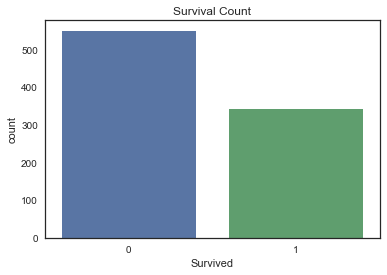

In [230]:
# Unfortunately, 62% of the passengers could not survive. Below is the bar chart for the absolute numbers
sns.countplot('Survived',data=train).set_title('Survival Count')

In [231]:
# Survival Rates by Gender
pd.crosstab(train.Survived, train.Sex, normalize='index')

Sex,female,male
Survived,,
0,0.147541,0.852459
1,0.681287,0.318713


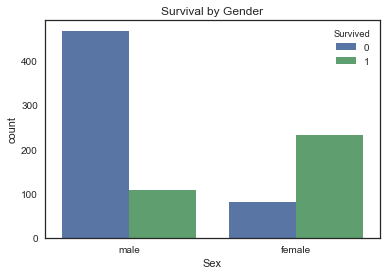

In [232]:
# Plot the survival count by Gender
sns.countplot('Sex',hue='Survived',data=train).set_title('Survival by Gender')

Females have very high chances of survival compared to the males - 68% vs. 32% respectively

In [233]:
# Next we will explore the Passenger Class variable
pd.crosstab(train.Survived, train.Pclass, normalize='index')

Pclass,1,2,3
Survived,,,
0,0.145719,0.176685,0.677596
1,0.397661,0.254386,0.347953


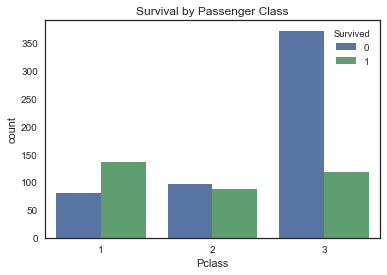

In [234]:
# Plot the survival count by Passenger Class
sns.countplot('Pclass',hue='Survived',data=train).set_title('Survival by Passenger Class')

At first glance, it looked like 35% survivors from 3rd class is not far behind the 40% from 1st class. But the maximum non survivors are also coming the 3rd class - 68%.
When we dug deeper into this by looking at the absolute count, we found that majority of passengers are from the 3rd class. Even though maximum passengers come from 3rd class, it clearly looks like the passengers from the 1st class (rich people) were given priority in terms of rescue/safety measures.

Next we also wanted to check the relationship between the passenger class and fare to see if fare provides obvious/redundant information. From the boxplot below, we found that the fares are way too high for the upper class (obvious information) but there are still outliers in each class. But basically, the more you pay, the higher class you will get and eventually have better chances to be rescued

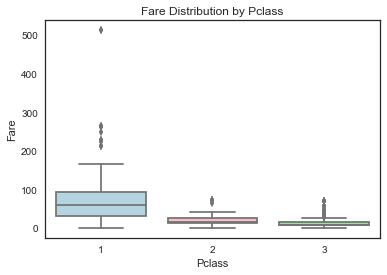

In [235]:
# Create a boxplot for the Fare distribution of each class
sns.boxplot("Pclass", "Fare", data=train, palette=["lightblue", "lightpink", "lightgreen"]).set_title('Fare Distribution by Pclass')

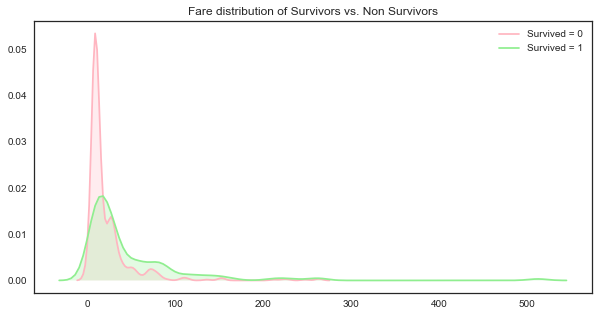

In [236]:
# Same story told by the fare distributions of survived vs. non survived passensers below
plt.figure(figsize = (10,5))
sns.kdeplot(train["Fare"][train.Survived == 0], color = "lightpink", shade = True)
sns.kdeplot(train["Fare"][train.Survived == 1], color = "lightgreen", shade = True)
plt.title("Fare distribution of Survivors vs. Non Survivors")
plt.legend(['Survived = 0', 'Survived = 1'])
plt.show()

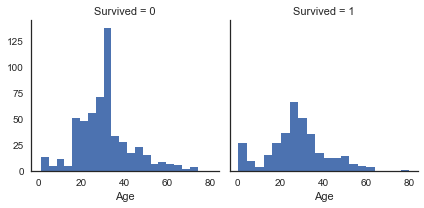

In [237]:
# Let's look into the Age factor
# Like fare, it is a continuous variable so let's plot a histogram to check the distribution
sns.FacetGrid(train, col='Survived').map(plt.hist, 'Age', bins=20)

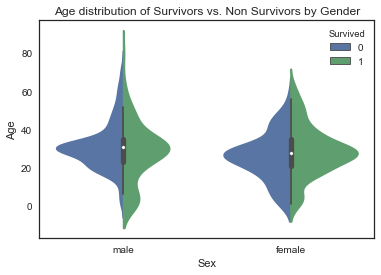

In [238]:
# Create a violin plot to check the distribution of Age across the Survivors vs. Non Survivors for each Gender
sns.violinplot("Sex","Age", hue="Survived", data = train, split = True).set_title("Age distribution of Survivors vs. Non Survivors by Gender")

From the histogram, we can see that the non survivors count is very high above 30 yrs of age and maximum survivors seem to be either < 10 yrs or between 20-30. From the violin plot split by Gender, we can say that, generally speaking, the females have higher chances of survival despite the given age. But below 15 there is some (very little though) evidence that young boys have better survival chances than girls of their age, but that could be just a matter of overall count

In [239]:
# Next, we explore the Embarked variable
pd.crosstab(train.Survived, train.Embarked, normalize='index')

Embarked,C,Q,S
Survived,,,
0,0.136612,0.085610,0.777778
1,0.271930,0.087719,0.640351


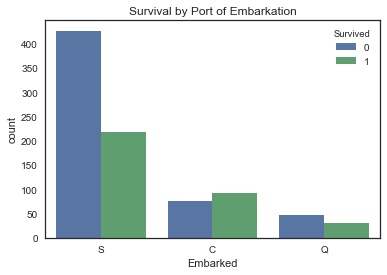

In [240]:
# Plot the absolute count of Survivors by Port
sns.countplot('Embarked',hue='Survived',data = train).set_title('Survival by Port of Embarkation')

From the cross tab, we see that Port S, Southampton seem to have the highest proportion of survivors, but even higher non-survivors. But it could be due to the majority of passengers from that port. The bar plot confirms that and we can also see that passengers boarding at Port C, Cherbourg have the maximum chances of survival.
Even though Port S has such a high number of passengers, it has very low survival rate. Let's dive deep into other factors explaining that.

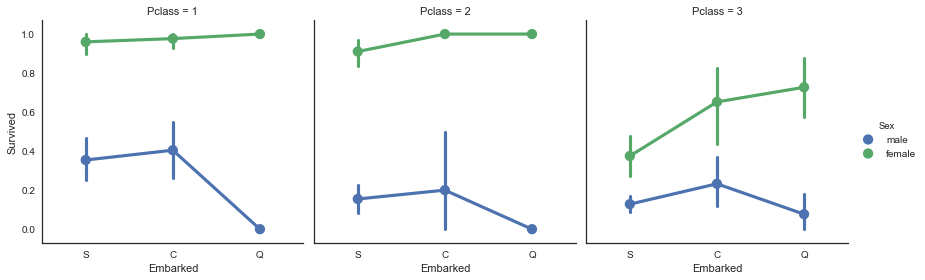

In [241]:
# Create a factor plot to include Pclass and Gender variables
sns.factorplot('Embarked', 'Survived', hue = 'Sex', col = 'Pclass', data = train)

The males from the port of Queentown have the least survival chances, whereas the females from the same port have the highest (Literally, "Queens' Town"!). Females from class 1 & 2, especially from Port C & Q have extremely high survival rates. Port S has slightly better survival chances than Port Q, only if the passenger is a male.

In [242]:
# Check if the ticket variable has any value add
#train.groupby('Ticket').size()
len(train.Ticket.unique())

681

Each passenger will have a different ticket number (except very few!). Probably there would be a pattern for different offers onboard but assuming class will take care of that, so there is no value add to the analysis from this variable.

In [243]:
# Drop the ticket variable
train.drop(['Ticket'],axis=1,inplace=True)

In [244]:
# Next, let's explore the SibSp variable
pd.crosstab(train.Survived, train.SibSp, normalize='index')

SibSp,0,1,2,3,4,5,8
Survived,,,,,,,
0,0.724954,0.176685,0.027322,0.021858,0.027322,0.009107,0.01275
1,0.614035,0.327485,0.038012,0.011696,0.008772,0.000000,0.00000


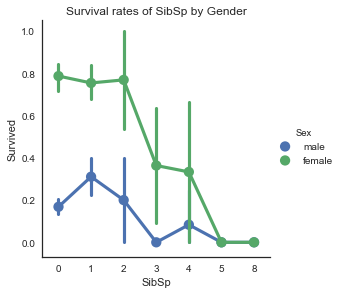

In [245]:
# Create a factor plot to include Gender
sns.factorplot('SibSp', 'Survived', hue = 'Sex', data = train)
sns.plt.title('Survival rates of SibSp by Gender')

From the crosstab, we see that the highest number of survivors are from the category which does not have any sibling (or spouse) aboard. The factor plot reveals that if the passenger is a female, she still has very similar chances of survival whether travelling alone or with 1-2 siblings/spouse. Probably the "partner" would make sure that their female travel partner is safe first. Interestingly, the males have better chances of survival when they travel with a partner (mutual care!) and not just alone.

In [246]:
# Lastly, we take a look at the Parch variable
pd.crosstab(train.Survived, train.Parch, normalize='index')

Parch,0,1,2,3,4,5,6
Survived,,,,,,,
0,0.810565,0.096539,0.072860,0.003643,0.007286,0.007286,0.001821
1,0.681287,0.190058,0.116959,0.008772,0.000000,0.002924,0.000000


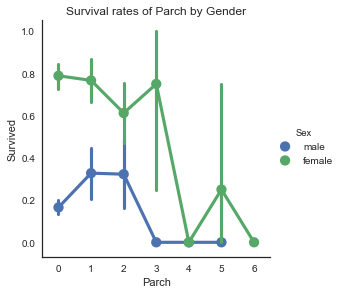

In [247]:
# Create a factor plot to include Gender
sns.factorplot('Parch', 'Survived', hue = 'Sex', data = train)
sns.plt.title('Survival rates of Parch by Gender')

From the crosstab, we can see that the highest number of survivors are from the category which does not have any family aboard. But the story is similar to the sibling/spouse variable.
From the factor plot, we see that the females have very high chances of survival when they travel alone or the number of parents/children is 1-3. Males have some chances of survival when they travel alone or a little higher when the number of parents/children is 1-2, but zero chances when that exceeds 2. Overall, survival is more likely if travelling in alone or in a small family.

### Step 3: Model Development

#### Now that the EDA is done, we are ready to process the data for the model development which also requires some feature engineering.

In [248]:
# From the 12 columns of the training dataset, we have already dropped Cabin and Ticket
# We do not need Name and PassengerID, so let's drop them
train.drop(['Name','PassengerId'],axis=1,inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null object
Age         891 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    891 non-null object
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


Now let's look at some of the variables that need to be transformed/formatted.
- Pclass looks fine as it is an integer variable with a hierarchy, so no changes required.
- For Age, we create buckets so as to make it categorical from conitnuous. The buckets are - Child : <=12, Teenager : 13-20, Adult : 21-35, Middle Aged : 35-50, and Old : >50.
- Same as Age, Fare is a continuous variable and hence we create buckets based on the univariate distribution found at the beginning of this exercise rounded off to nearest integers.
- Last, for the SibSp and Parch variable, which essentially indicate how many people from family (Sibling, Spouse, Parents and Children) are travelling along with the passenger, we create a new continuous variable as family size ( 1 for teh passenger plus any additional travellers coming from family). From family size, we create buckets to indicate as whether the traveller is alone (1), small family (2-4) or has a big family (>4).

In [249]:
# Convert the male and female groups to integer form
train["Gender"] = 0
train.loc[train['Sex']=='male','Gender']=0
train.loc[train['Sex']=='female','Gender']=1

# Convert the Embarked classes to integer form
train["Port"] = 0
train.loc[train['Embarked']=='S','Port']=0
train.loc[train['Embarked']=='C','Port']=1
train.loc[train['Embarked']=='Q','Port']=2

# Create buckets for Age
train["Age_cat"] = 0
train.loc[train['Age']<=12,'Age_cat']=0
train.loc[(train['Age']>12)&(train['Age']<=20),'Age_cat']=1
train.loc[(train['Age']>20)&(train['Age']<=35),'Age_cat']=2
train.loc[(train['Age']>35)&(train['Age']<=50),'Age_cat']=3
train.loc[train['Age']>50,'Age_cat']=4

# Create buckets for Fare
train["Fare_cat"] = 0
train.loc[train['Fare']<=8,'Fare_cat']=0
train.loc[(train['Fare']>8)&(train['Fare']<=15),'Fare_cat']=1
train.loc[(train['Fare']>15)&(train['Fare']<=31),'Fare_cat']=2
train.loc[train['Fare']>31,'Fare_cat']=3

# Create a new variable family size and buckets for the same as travel_company
train["family_size"] = train["SibSp"] + train["Parch"] + 1
train["travel_company"] = 0
train.loc[train['family_size']<=1,'travel_company']=0
train.loc[(train['family_size']>1)&(train['family_size']<=4),'travel_company']=1
train.loc[train['family_size']>4,'travel_company']=2

In [250]:
# Remove the unneccessary vaiables and make sure the new variables got added
#train.describe()
#train.info()
train.drop(['Sex','Age','SibSp','Parch','Fare','Embarked','family_size'],axis=1,inplace=True)
#train.describe()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
Survived          891 non-null int64
Pclass            891 non-null int64
Gender            891 non-null int64
Port              891 non-null int64
Age_cat           891 non-null int64
Fare_cat          891 non-null int64
travel_company    891 non-null int64
dtypes: int64(7)
memory usage: 48.8 KB


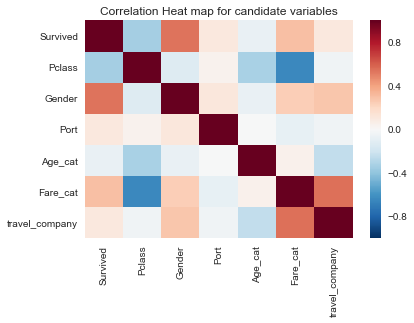

In [251]:
# Check the correlation among the rest of the available variables
sns.heatmap(train.corr()).set_title('Correlation Heat map for candidate variables')

There is slightly positive correlation between Fare category and travel company which could mean if you are travelling alone, you could adjust in cabins with lower fares but when you travel with family/partner, you would prefer better stay arrangements. There is also a strong negative correlation between Passenger class and Fare category because higher the class (1 being highest here), the more fare you pay. We can still keep these in the preliminary model and see if removing Fare gives a better model later.

#### Time to finally start developing the prediction model. 
Since the test dataset provided does not have the final response variable to check for accuracy ourselves, we will split the current training dataset by the 80/20 rule. Also, we will try out a few techniques and see which one makes the best prediction and then finally apply that one to the final test dataset on Kaggle.

In [252]:
# Separating the response (y) and explanatory (x) variables
#X = train[["Pclass", "Gender", "Port", "Age_cat", "Fare_cat", "travel_company"]].values
# Removing the Fare category increases the model accuracy, so decided to exclude that from the final models
X = train[["Pclass", "Gender", "Port", "Age_cat", "travel_company"]].values
y = train["Survived"].values

In [253]:
# Splitting the dataset into test and training with 80% for training the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=25)

In [254]:
# Building the Logistic Regression model using the training dataset
LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)

# Testing the model with the test dataset (do not confuse with the actual Test dataset)
y_pred = LogReg.predict(X_test)
print('The model accuracy is', metrics.accuracy_score(y_pred, y_test))
print('The R-square value is', metrics.r2_score(y_pred, y_test)) 
#Although R-square doesn't provide a lot of info in binary models

The model accuracy is 0.798882681564
The R-square value is 0.118226600985


In [255]:
# Building the Decision tree model using the training dataset
DecTree = tree.DecisionTreeClassifier()
DecTree.fit(X_train, y_train)

# Testing the model with the test dataset (do not confuse with the actual Test dataset)
y_pred = DecTree.predict(X_test)
print('The model accuracy is', metrics.accuracy_score(y_pred, y_test))
print('The R-square value is', metrics.r2_score(y_pred, y_test))
#Although R-square doesn't provide a lot of info in binary models

The model accuracy is 0.810055865922
The R-square value is 0.140395480226


In [256]:
# Building the Random forest model using the training dataset
RandFor = RandomForestClassifier(max_depth = 6, min_samples_split=2, n_estimators = 100, random_state = 1)
RandFor.fit(X_train, y_train)

# Testing the model with the test dataset (do not confuse with the actual Test dataset)
y_pred = RandFor.predict(X_test)
print('The model accuracy is', metrics.accuracy_score(y_pred, y_test))
print('The R-square value is', metrics.r2_score(y_pred, y_test))
#Although R-square doesn't provide a lot of info in binary models

The model accuracy is 0.826815642458
The R-square value is 0.177925925926


In [257]:
# Also compare the feature importance of the Decision tree and Random forest models
print(DecTree.feature_importances_)
print(RandFor.feature_importances_)

[ 0.18806676  0.53750269  0.01577471  0.10830689  0.15034895]
[ 0.18677212  0.52149811  0.04503794  0.13873524  0.1079566 ]


### Step 4: Make Predictions on unseen data

#### Based on the above comparison, I choose to go with the Random Forest model as it has the highest accuracy score. Now, finally coming to the actual aim of the project - Predict survival on the test dataset and submit to Kaggle.

In [258]:
# Pre-process and transform the data same as the training dataset
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [259]:
# Impute missing values of age by the respective average of the genders
test.loc[(test.Age.isnull())&(test.Sex=='female'),'Age'] = test["Age"][test["Sex"] == 'female'].mean()
test.loc[(test.Age.isnull())&(test.Sex=='male'),'Age'] = test["Age"][test["Sex"] == 'male'].mean()
test.Age.isnull().any()

# Fare not included in the final model, but in case we want to revert, need to treat missingness
# Impute the missing value of fare by the pclass median
test.loc[(test.Fare.isnull())&(test.Pclass==1),'Fare'] = test["Fare"][test["Pclass"] == 1].median()
test.loc[(test.Fare.isnull())&(test.Pclass==2),'Fare'] = test["Fare"][test["Pclass"] == 2].median()
test.loc[(test.Fare.isnull())&(test.Pclass==3),'Fare'] = test["Fare"][test["Pclass"] == 3].median()
test.Fare.isnull().any()

# Since Cabin will be dropped so, not required to fill the missing values

# Convert the male and female groups to integer form
test["Gender"] = 0
test.loc[test['Sex']=='male','Gender']=0
test.loc[test['Sex']=='female','Gender']=1

# Convert the Embarked classes to integer form
test["Port"] = 0
test.loc[test['Embarked']=='S','Port']=0
test.loc[test['Embarked']=='C','Port']=1
test.loc[test['Embarked']=='Q','Port']=2

# Create buckets for Age
test["Age_cat"] = 0
test.loc[test['Age']<=12,'Age_cat']=0
test.loc[(test['Age']>12)&(test['Age']<=20),'Age_cat']=1
test.loc[(test['Age']>20)&(test['Age']<=35),'Age_cat']=2
test.loc[(test['Age']>35)&(test['Age']<=50),'Age_cat']=3
test.loc[test['Age']>50,'Age_cat']=4

# Create  buckets for family size/travel company
test["family_size"] = test["SibSp"] + test["Parch"] + 1
test["travel_company"] = 0
test.loc[test['family_size']>=1,'travel_company']=0
test.loc[(test['family_size']>1)&(test['family_size']<=4),'travel_company']=1
test.loc[test['family_size']>4,'travel_company']=2

test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Gender,Port,Age_cat,family_size,travel_company
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,1100.500000,2.265550,30.272597,0.447368,0.392344,35.560845,0.363636,0.464115,2.100478,1.839713,0.442584
std,120.810458,0.841838,12.634534,0.896760,0.981429,55.856972,0.481622,0.685516,0.900013,1.519072,0.585848
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,996.250000,1.000000,23.000000,0.000000,0.000000,7.895800,0.000000,0.000000,2.000000,1.000000,0.000000
50%,1100.500000,3.000000,30.272362,0.000000,0.000000,14.454200,0.000000,0.000000,2.000000,1.000000,0.000000
75%,1204.750000,3.000000,35.750000,1.000000,0.000000,31.471875,1.000000,1.000000,2.750000,2.000000,1.000000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200,1.000000,2.000000,4.000000,11.000000,2.000000


In [260]:
# Extract the features from the test set and predict using the final model
test_features = test[["Pclass", "Gender", "Port", "Age_cat", "travel_company"]].values
test_Survived = RandFor.predict(test_features)

# Create a data frame with two columns: PassengerId & Survived for the final submission
Titanic_Prediction = pd.DataFrame({'PassengerId' : test.loc[:,'PassengerId'],
                                   'Survived': test_Survived})

# Checking for the final dimensions : 418 x 2
print(Titanic_Prediction.shape)

# Export to a csv file
Titanic_Prediction.to_csv("Titanic_Prediction.csv", index=False)

(418, 2)


#### Conclusion from the Titanic Survival Analysis :-
- Findings from EDA - If you were on "the Titanic", your chances to survive would be the highest if you are a young female (or a child), have enough money to buy high fared tickets to get into a 1st class cabin, travelling in small family and getting aboard at the Port of Cherbourg.
- Model development - Out of the three models tried out, Random Forest predicts the survival with the highest accuracy-83%. Logistic regression is good to start with, but for a model to better capture the interactions for a non linear data, decision tree is a better choice. Random Forest does even better than decision tree because overfitting could be a problem with the later. This can be reduced to some degree by creating an ensemble of randomized decison trees which essentially is what Random Forest does. Although, it can still be improved with more advanced techniques like SVM, AdaBoost, Naive Bayes, GBM, etc., but as a beginner, I would recommend to start with these basic models first. Later, we could also introduce the concept of hyperparameter optimization/tuning.

Some useful resources that I went through to write the final script (basics, viz & machine learning) :-
- http://www.developintelligence.com/blog/2017/08/data-cleaning-pandas-python
- https://pandas.pydata.org/pandas-docs/stable/missing_data.html
- https://stackoverflow.com/questions/21247203/how-to-make-a-pandas-crosstab-with-percentages
- https://python-graph-gallery.com/
- https://jakevdp.github.io/PythonDataScienceHandbook/04.14-visualization-with-seaborn.html
- http://seaborn.pydata.org/tutorial/aesthetics.html
- https://jakevdp.github.io/PythonDataScienceHandbook/05.00-machine-learning.html